In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import torch
import torchvision

from pathlib import Path
from PIL import Image
from torch import Tensor
from typing import Callable, Iterable, List, Optional, Tuple

In [2]:
from matplotlib import pyplot as plt

In [3]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [4]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [5]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
# image_id = str(df.loc[0, 'image_id'])
image_id = str(df.iloc[0, 0])
path = DATA_DIR/'train'/(image_id + '.jpg')
print(path)
# Image.open(path)

/media/dmitry/data/global-wheat-detection/train/b6ab77fd7.jpg


In [7]:
image = cv2.imread(str(path), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
img_annots = df[df['image_id'] == image_id]
img_annots.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


In [9]:
def read_bbox(bbox: str):
    bb = map(float, bbox[1:-1].split(','))
    bb = list(map(int, bb))
    if len(bb) < 4:
        raise ValueError("Dumb bbox: {}".format(bbox))
    return bb

In [10]:
for bbox in img_annots['bbox']:
    x0, y0, w, h = read_bbox(bbox)
    x1, y1 = x0 + w, y0 + h
    image = cv2.rectangle(image, (x0, y0), (x1, y1), (255, 0, 0), 1)

In [11]:
# Image.fromarray(image)

In [12]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)

In [13]:
def make_dataset(image_dir: str, filenames: Iterable[str]) -> List[str]:
    images = []
    image_dir = os.path.expanduser(image_dir)
        
    if not os.path.isdir(image_dir):
        raise RuntimeError("Unable to read folder {}".format(image_dir))
        
    for fname in filenames:
        path = os.path.join(image_dir, fname)
        images.append(path)   
    return images

In [14]:
class WheatDataset(torchvision.datasets.VisionDataset):
    def __init__(self, image_dir, csv, transforms=None, transform=None, target_transform=None):
        super(WheatDataset, self).__init__(image_dir, transforms, transform, target_transform)
        
        df = pd.read_csv(csv)
        ids = df['image_id'].unique()
        filenames = map(lambda x: x + '.jpg', ids)
        self.images = make_dataset(image_dir, filenames)
        
        all_bboxes = []
        for image_id in ids:
            img_anns = df[df['image_id'] == image_id]
            img_bboxes = []
            
            for bbox in img_anns['bbox']:
                x0, y0, w, h = read_bbox(bbox)
                x1, y1 = x0 + w, y0 + h
                bb = torch.tensor([x0, y0, x1, y1], dtype=torch.int16)
                img_bboxes.append(bb)
            
            all_bboxes.append(torch.stack(img_bboxes))
        
        self.annotations = all_bboxes
        
    def __getitem__(self, index):
        path = self.images[index]
        bboxes = self.annotations[index]
        
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        for bb in bboxes:
            cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 1)
            
        return image, bboxes

    def __len__(self):
        return len(self.images)

In [15]:
%%time

image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

ds = WheatDataset(image_dir, csv_path)

CPU times: user 21.5 s, sys: 11.6 ms, total: 21.6 s
Wall time: 21.6 s


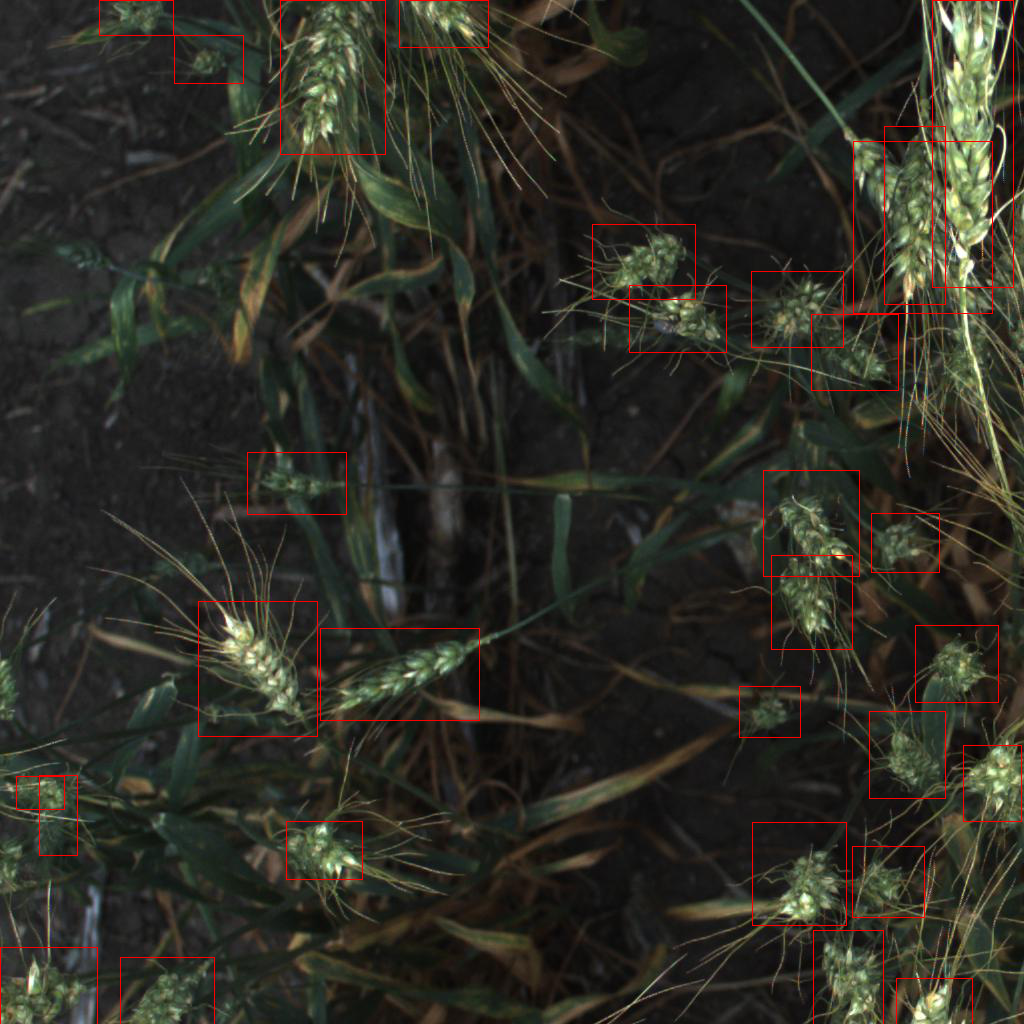

In [16]:
image, bboxes = ds[7]

Image.fromarray(image)